In [70]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_4cAhnJ_JWTBdMu9iBKy1K1quPEj7kMqsG2qDCs7LXdYRMKELA3pDdjcD2akLVo5TNyprrM")

In [71]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model

conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(600, 600, 3))
input_image = Input(shape=( 600,600, 3))  # Input for the right branch
conv  = conv_base(input_image)  # Apply the same conv_base to the right branch
flaten = Flatten()(conv)
FC_layer = Dense(1024, activation='relu')(flaten)
Featur_vector = Dense(512, activation='sigmoid')(FC_layer)

# Create the model
final_model = Model(inputs= input_image , outputs= Featur_vector)

# Compile the model
final_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Print the summary
final_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 600, 600, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 18, 18, 512)       14714688  
                                                                 
 flatten_5 (Flatten)         (None, 165888)            0         
                                                                 
 dense_10 (Dense)            (None, 1024)              169870336 
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
Total params: 185109824 (706.14 MB)
Trainable params: 185109824 (706.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


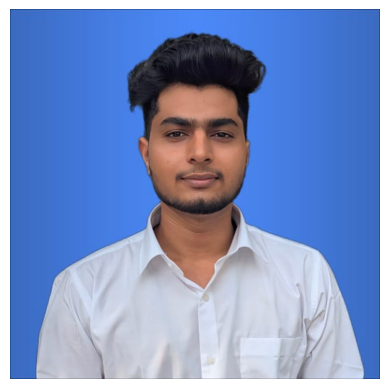

In [72]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = '/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/CBIR_System/media/photos/photo.jpeg'
img = Image.open(path)  # Open the image
img = img.resize((600, 600))  # Resize the image
img_array = np.array(img)  # Convert to NumPy array
plt.imshow(img_array)  # Display the image
plt.axis('off')  # Hide axes
plt.show()


In [73]:
embedding = final_model.predict(img_array.reshape(1,600,600,3))

1/1 [==============================] - 0s 105ms/step


In [74]:
embedding.shape

(1, 512)

In [75]:
full_name = "yash harishchandra karambe"
age = 22 
embedding_id = f"{full_name}_{age}"
embedding_id

'yash harishchandra karambe_22'

In [76]:
import pinecone
index_name = "image-similarity"  


pc = pinecone.Pinecone(api_key='pcsk_4cAhnJ_JWTBdMu9iBKy1K1quPEj7kMqsG2qDCs7LXdYRMKELA3pDdjcD2akLVo5TNyprrM')
# 
# Create index if it doesn't exist
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,  # Replace with your model dimensions
        metric="cosine",  # Replace with your model metric
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )
    print(f"Index '{index_name}' created.")
else:
    print(f"Index '{index_name}' already exists.")

index = pc.Index(index_name)

Index 'image-similarity' created.


In [77]:
index = pc.Index(index_name)  # Connect to the created index

In [100]:
embedding_data = np.array(embedding, dtype=np.float32)
embedding_data = embedding_data.tolist()

In [ ]:
index.upsert(
    vectors=[
        {"id": embedding_id, "values": embedding_data[0]}
    ]
)

{'upserted_count': 1}

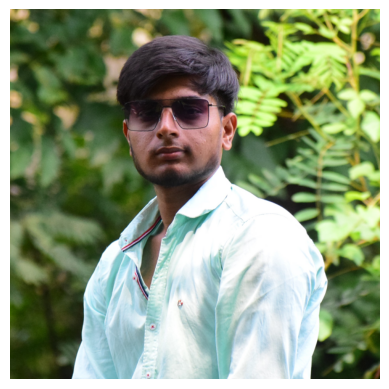

In [94]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

path = "/mnt/c/Users/YASH/OneDrive/Desktop/CBIR_System/CBIR_System/media/photos/DSC_0065.JPG"
img = Image.open(path)  # Open the image
img = img.resize((600, 600))  # Resize the image
img_array = np.array(img)  # Convert to NumPy array
plt.imshow(img_array)  # Display the image
plt.axis('off')  # Hide axes
plt.show()

In [95]:
query_vector = final_model.predict(img_array.reshape(1,600,600,3))

1/1 [==============================] - 0s 22ms/step


In [97]:
query_vector = np.array(query_vector, dtype=np.float32)
query_vector = query_vector.tolist()

In [98]:

results = index.query(
    vector=query_vector,
    top_k=5,  # Number of results to retrieve
    include_metadata=False
)

In [99]:
results

{'matches': [{'id': 'yash harishchandra karambe_22',
              'score': 0.719740391,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 5}}